In [28]:
import json
import glob
import re
import pandas as pd
import polars as pl
from os import path
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import math

data_dir = '../out'

In [29]:
all_files = glob.glob(path.join(data_dir, "gen_*.json"))
gen_pattern = 'gen_0*([0-9]*).json$'

def extract_gen_number(filename):
    return int(re.search(gen_pattern, filename).group(1))

all_files.sort(key=extract_gen_number)
all_files

['../out/gen_001.json',
 '../out/gen_002.json',
 '../out/gen_003.json',
 '../out/gen_004.json',
 '../out/gen_005.json',
 '../out/gen_006.json',
 '../out/gen_007.json',
 '../out/gen_008.json',
 '../out/gen_009.json',
 '../out/gen_010.json',
 '../out/gen_011.json',
 '../out/gen_012.json',
 '../out/gen_013.json',
 '../out/gen_014.json',
 '../out/gen_015.json']

In [30]:
#
# Pure Polars way.  It's a bit wonky because of the limitations of read_json
#

import dpath.util
import io

particles = []
meta = []
for idx,file in enumerate(all_files):
    with open(file) as f:
        data = json.load(f)
        particles_bit = json.dumps([x["parameters"] for x in data["pop"]["normalised_particles"]])
        scores_bit = [x["scores"] for x in data["pop"]["normalised_particles"]]
        gen_number = extract_gen_number(file)
        
        particles.append(
            pl.read_json(io.StringIO(particles_bit)) # Complex, but should pick up multiple parameters automatically
            .with_column(pl.lit(gen_number).alias("gen_number"))
            .with_column(pl.Series("scores", scores_bit))
        )

        meta.append(pl.DataFrame()
            .with_column(pl.lit(gen_number).alias("generation"))
            .with_column(pl.lit(data["pop"]["tolerance"]).alias("tolerance"))
            .with_column(pl.lit(data["pop"]["acceptance"]).alias("acceptance"))
        )

particle_df = pl.concat(particles)
meta_df = pl.concat(meta)

print(particle_df.head(3))
print(meta_df.head(3))


shape: (3, 3)
┌──────────┬────────────┬────────────────────────┐
│ heads    ┆ gen_number ┆ scores                 │
│ ---      ┆ ---        ┆ ---                    │
│ f64      ┆ i32        ┆ list[f64]              │
╞══════════╪════════════╪════════════════════════╡
│ 0.449921 ┆ 1          ┆ [0.23, 0.22, ... 0.18] │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 0.793416 ┆ 1          ┆ [0.12, 0.06, ... 0.14] │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 0.228345 ┆ 1          ┆ [0.45, 0.41, ... 0.43] │
└──────────┴────────────┴────────────────────────┘
shape: (3, 3)
┌────────────┬────────────┬────────────┐
│ generation ┆ tolerance  ┆ acceptance │
│ ---        ┆ ---        ┆ ---        │
│ i32        ┆ f64        ┆ f64        │
╞════════════╪════════════╪════════════╡
│ 1          ┆ 1.7977e308 ┆ 1.0        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 2          ┆ 0.441583   ┆ 1.0        │
├╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌┤
│ 3          ┆ 0.327917   ┆ 1.0        │
└

In [31]:
#
# Pandas way
#

# particle_dfs_list = []
# meta_dfs_list = []
# for filename in all_files:
#     gen_number = extract_gen_number(filename)
    
#     with open(filename) as f:
#         data = json.load(f)
        
#     new_p_df = pd.json_normalize(data['pop'], record_path=['normalised_particles'])
#     new_p_df['generation'] = gen_number

#     meta = {
#         'generation': gen_number, 
#         'tolerance': data['pop']['tolerance'], 
#         'acceptance': data['pop']['acceptance']
#     }
#     new_m_df = pd.DataFrame(data=meta, index=[gen_number])

#     meta_dfs_list.append(new_m_df)
#     particle_dfs_list.append(new_p_df)

# particle_df = pd.concat(particle_dfs_list)
# particle_df = particle_df.reset_index()

# meta_df = pd.concat(meta_dfs_list)
# meta_df = meta_df.reset_index()
# meta_df = meta_df.drop('index', axis=1)
# meta_df['generation'] = meta_df.generation.astype('category') 

# print(meta_df.dtypes)
# print(meta_df)

# particle_df['mean_score'] = particle_df['scores'].map(mean)
# df = particle_df.drop('scores', axis=1)

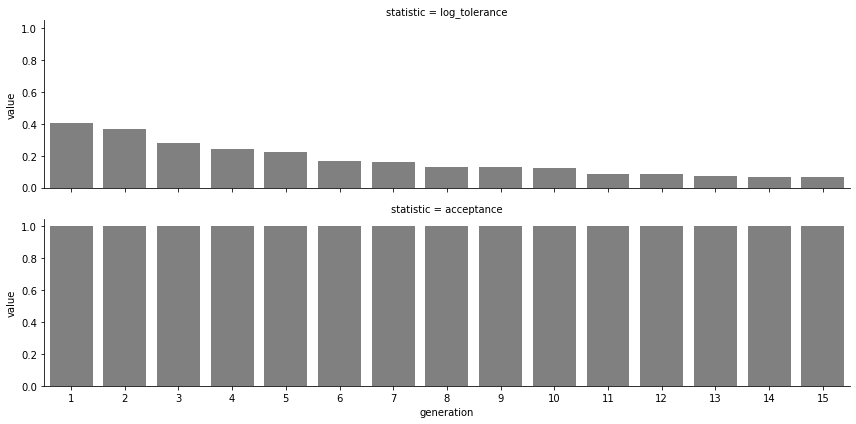

In [32]:
meta_df['log_tolerance'] = meta_df['tolerance'].apply(lambda x: math.log(1 + min(x, 0.5)))
meta_melt = meta_df.melt('generation', variable_name='statistic', value_vars=['log_tolerance', 'acceptance'])

sns.FacetGrid(
    meta_melt.to_pandas(), 
    row="statistic",
    aspect=4,
).map_dataframe(
    sns.barplot,
    x='generation', 
    y='value',
    color='grey'
)


In [33]:
meta_df

generation,tolerance,acceptance,log_tolerance
i32,f64,f64,f64
1,1.7977e308,1.0,0.405465
2,0.441583,1.0,0.365742
3,0.327917,1.0,0.283611
4,0.273167,1.0,0.241507
5,0.252583,1.0,0.225208
6,0.185333,1.0,0.170024
7,0.173583,1.0,0.160062
8,0.139583,1.0,0.130663
9,0.135583,1.0,0.127146


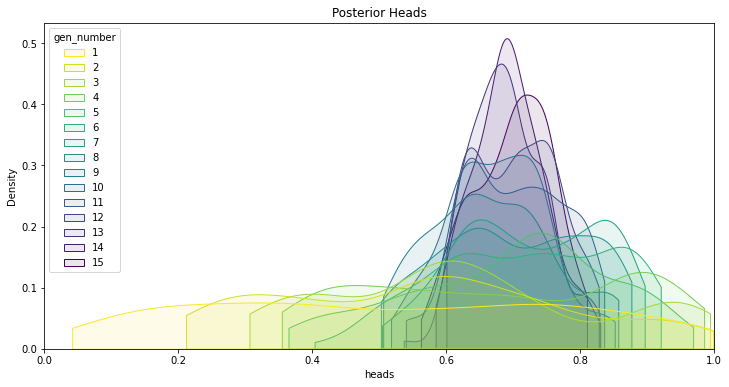

In [34]:
# sns.set_theme()
fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(0, 1)

sns.kdeplot(
   data=particle_df.to_pandas(), 
   x="heads", 
   hue='gen_number',
   fill=True, 
   palette="viridis_r",
   alpha=.1, 
   linewidth=1,
   bw_adjust=.8, 
   cut=0, 
).set(title='Posterior Heads')
sns.move_legend(ax, "upper left")

[Text(0.5, 1.0, 'Mean Score Distribution')]

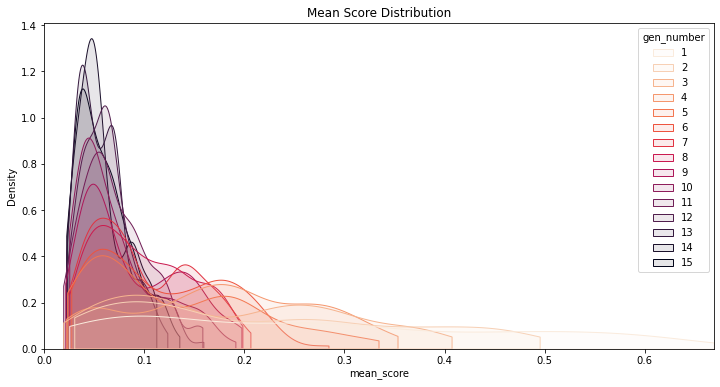

In [35]:
#sns.set_theme()

particle_df["mean_score"] = particle_df["scores"].apply(lambda l: mean(l))

fig, ax = plt.subplots(figsize=(12,6))
score_max = max(particle_df['mean_score'])
ax.set_xlim(0, score_max)
sns.kdeplot(
    data=particle_df.to_pandas(), 
    x='mean_score', 
    hue='gen_number',
    fill=True, 
    palette="rocket_r",
    alpha=.1, 
    linewidth=1,
    bw_adjust=.8, 
    cut=0,
).set(title='Mean Score Distribution')